<img src="https://www.wellcomeconnectingscience.org/wp-content/themes/new_wellcome_connecting_science/dist/assets/svg/logo.svg" alt="WCS Logo" width="150" style="float: left;">
<img src="https://github.com/EveliaCoss/Tutorial_ISCB_LATAM_scATACseq/blob/main/Logo_JAGUAR.png?raw=true" alt="WCS Logo" width="150" style="float: right;">





<h1><center>
  Practical 6: CITE-seq normalization and background correction
  </center>

## About the course 📌

This course is part of the Workshop [Single Cell Genomic Approaches to Study the Immune System - Latin America & the Caribbean](https://coursesandconferences.wellcomeconnectingscience.org/event/single-cell-genomic-approaches-to-study-the-immune-system-latin-america-the-caribbean-20241109/) (9-11 Novembrer 2024), Universidad CES, Medellín, Colombia.

- **Date:** 10 November 2024
- **Course duration**: 3 hours

**Speakers:**
- <font color='orange'>Danilo Ceschin</font> - PI, Centro de Investigación en Medicina Tralaslacional “Severo R. Amuchástegui” (CIMETSA), Instituto Universitario de Ciencias Biomédicas de Córdoba, Argentina.
- <font color='orange'>Felipe Gajardo</font> - PostDoc, Laboratory of Epigenetics, Pontificia Universidad Catolica de Chile.

If you want to come back to the Github, please follow the next link:
*   Github: https://github.com/WCSCourses/Single_Cell_Genomics_ImmuneSys_24


<center>

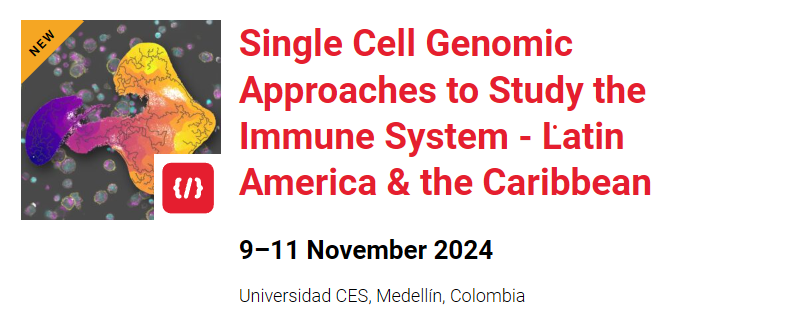

</center>

**Let's start!** In this practical we will learn two different methods for normalization of CITEseq data.

1. Centered Log Ratio (CLR) ([Stoeckius et al., 2017](https://www.nature.com/articles/nmeth.4380))
2. DSB background correction ([Mulé et al., 2022](https://www.nature.com/articles/s41467-022-29356-8))

But, we need to get some things done before proceeding with the fun part. Don't worry, it'll be quick, I promise.

# 1️⃣ **Setting Up the Environment in Google Colab** 💻

## 1.1. Cleaning the R environment
This step is used to clean up the R environment. By removing all objects with rm(list=ls()), you ensure that no previous variables interfere with your current analysis. Running gc() triggers garbage collection, which helps manage memory usage, especially important when working with large CITE-Seq datasets.

In [ ]:
### clean environment
rm(list=ls())
gc()


,used,(Mb),gc trigger,(Mb),max used,(Mb)
Ncells,652998,34.9,1445650,77.3,1324522,70.8
Vcells,1214705,9.3,8388608,64.0,1924960,14.7


## 1.2. Custom Shell Call Function for Google Colab
Google Colab typically runs Python as the default environment. This function lets you run shell commands from within R, ensuring compatibility with Colab’s infrastructure. It captures and prints the output of the shell commands. This functionality is useful when managing system configurations or installing packages in Colab while using the R kernel.



In [ ]:
## https://stackoverflow.com/questions/70025153/how-to-access-the-shell-in-google-colab-when-running-the-r-kernel
shell_call <- function(command, ...) {
  result <- system(command, intern = TRUE, ...)
  cat(paste0(result, collapse = "\n"))
}

## 1.3. Downloads and sets up the R2U
In this section, the script downloads and sets up the R2U repository for package management. R2U is a fast way to install R packages on Ubuntu (the operating system underlying Google Colab). This makes package installation quicker and more efficient. The script sets the appropriate permissions for the downloaded shell script, runs it, and then enables the bspm package for managing packages. After installation, the script is removed.

This is an important step to streamline package installations, reducing the time needed for installing necessary libraries for CITE-Seq data analysis, and ensuring that your environment is properly configured for your workflow.

In [ ]:
## Setup R2U
download.file("https://github.com/eddelbuettel/r2u/raw/master/inst/scripts/add_cranapt_jammy.sh",
              "add_cranapt_jammy.sh")
Sys.chmod("add_cranapt_jammy.sh", "0755")
shell_call("./add_cranapt_jammy.sh")
bspm::enable()
options(bspm.version.check=FALSE)
shell_call("rm add_cranapt_jammy.sh")


52 packages can be upgraded. Run 'apt list --upgradable' to see them.
Reading package lists...
Building dependency tree...
Reading state information...
ca-certificates is already the newest version (20240203~22.04.1).
gnupg is already the newest version (2.2.27-3ubuntu2.1).
gnupg set to manually installed.
wget is already the newest version (1.21.2-2ubuntu1.1).
0 upgraded, 0 newly installed, 0 to remove and 52 not upgraded.
-----BEGIN PGP PUBLIC KEY BLOCK-----

mQINBFM+sY8BEADA70T+U0/2WNjOTLvytuXLvBC4vgA8hYvOaBS1cL3d8lu4mwr4
W84/6p4v/mXle/0eIO2D2g+XfK72ZHZxpS+bb7yPxrkCDLGxwUd/khtTJHSbbKFo
J73AsABflMe+8qv+E74+QTiXErTCNioFRz18sa0EvOnEAiokau6TZVYY2z9YjBNI
yEjTi+z+g8c1RL6VmrFEpTicTpafOLbkRyw0VKnAKG7Ytp3Ksc1G9/IAoKw3Q9La
0DJb5iX6hyB7+PNid6htK4LtPKZ2dNSrnRvNNkjj5BgcM2AT1hmxbzHNzIVmPoKA
CQFrkdjog3/PcyjdtZG7cfoSDXrbIAZeAa2ngLv9C/DJatVDd6maPOe66gLo7+As
ErMvO9vtiouqLdurW+Lhx0jFW9Ca3g1taLfbSDyS3X1mOGWcisbQvBqkIuoDQTeS
V4Z04wrwTZ1HtweKG/s5fmPtZNGWVI5YNRLIwdmbGzFTMPu2XTAOd+xSK2H+46Kh
Sh4kFeP6pBh5No

Tracing function "install.packages" in package "utils"



## 1.4. Install and Load Required Packages
This function is essential for setting up your CITE-Seq analysis environment in R. It ensures that all required packages are installed and loaded, which is crucial when working with multiple packages for data visualization, statistical analysis, or single-cell analysis in CITE-Seq.

For this tutorial we will need some packages that will help us to download, load and analyse the data in R. Using the following code you should be able to install:

+ `dsb`, the R package that allows to perform background correction in CITEseq data.
+ `limma`, a dependence required by `dsb`.
+ `Seurat`, the swiss-knife toolkit for analysing single-cell data in R. Here, we will be using it for _(i)_ loading the sparse matrices to be processed by `dsb`, and _(ii)_ to perform Center Log Ratio (CLR) normalization.
+ `tidyverse`, a very useful toolkit for efficient data analysis in R.

In [ ]:
loadAndInstallPackages <- function(pkgs) {
  # Function to load packages with suppressed warnings and messages
  myrequire <- function(pkg) {
    suppressWarnings(suppressMessages(suppressPackageStartupMessages(require(pkg, character.only = TRUE))))
  }

  # Check which packages are not installed
  new.pkgs <- pkgs[!(pkgs %in% installed.packages()[, "Package"])]

  # Install missing packages
  if (length(new.pkgs) > 0) {
    message("Installing the following packages: ", paste(new.pkgs, collapse = ", "))
    if (!requireNamespace("BiocManager", quietly = TRUE))
      install.packages("BiocManager")
    BiocManager::install(new.pkgs, dependencies = TRUE)
  }

  # Load all packages, including newly installed ones
  ok <- sapply(pkgs, myrequire)

  # Report if any package could not be loaded
  if (!all(ok)) {
    message("The following packages could not be loaded: ", paste(pkgs[!ok], collapse = ", "))
  } else {
    message("All packages were successfully loaded.")
  }
}

#packages <- c("Seurat")

# package's list for using
packages <- c("limma", "dsb", "Seurat", "tidyverse")

# installation and/or calling packages
loadAndInstallPackages(packages)

Installing the following packages: limma, dsb, Seurat

'getOption("repos")' replaces Bioconductor standard repositories, see
'help("repositories", package = "BiocManager")' for details.
Replacement repositories:
    CRAN: https://cran.rstudio.com

Bioconductor version 3.20 (BiocManager 1.30.25), R 4.4.2 (2024-10-31)

Installing package(s) 'BiocVersion', 'limma', 'dsb', 'Seurat'

Old packages: 'knitr', 'waldo'

All packages were successfully loaded.



# 2️⃣ **Download and Uncompress CITE-Seq Count**


The count matrices contain the core data for single-cell multimodal analysis, including RNA and protein expression levels. Accessing this data is the foundational step for conducting subsequent analyses, such as exploring gene expression patterns or protein marker abundance across different cell types.

In [ ]:
# Download cells that passed the CellRanger filter
system("wget https://github.com/WCSCourses/Single_Cell_Genomics_ImmuneSys_24/raw/refs/heads/main/course_data/Module2_CITEseq/filtered_cells.txt")
stained_cells=read.table("filtered_cells.txt", col.names=c("Barcode"),header=F) %>%
  tibble %>% pull(Barcode)

# Download and uncompress count matrices

system("wget https://github.com/WCSCourses/Single_Cell_Genomics_ImmuneSys_24/raw/refs/heads/main/course_data/Module2_CITEseq/10X_multimodal_dataset_downsample3000.tar.gz")
system("tar xf 10X_multimodal_dataset_downsample3000.tar.gz")

# 3️⃣ **Quality Control filtering**

In this section we will perform the quality control (QC) of the data. This step is independent of the normalization method to be used and has to be done before normalization. Hence, we will focus on identifying those barcodes that sucessfully pass the QC to remove latter those failing from the input objects of each normalization method latter.

First, we load the count matrices as sparse matrices using Seurat's `Read10X` function.

In [ ]:
prot=Read10X("YASCP_downsample_3000_MEX_ADT")
rna=Read10X("YASCP_downsample_3000_MEX_GEX")

In [ ]:
# create metadata of droplet QC stats used in standard scRNAseq processing
mtgene = grep(pattern = "^MT-", rownames(rna), value = TRUE) # used below

md = data.frame(
  rna.size = log10(Matrix::colSums(rna)),
  prot.size = log10(Matrix::colSums(prot)),
  n.gene = Matrix::colSums(rna > 0),
  mt.prop = Matrix::colSums(rna[mtgene, ]) / Matrix::colSums(rna)
)

# add indicator for barcodes Cell Ranger called as cells
md$drop.class = ifelse(rownames(md) %in% stained_cells, 'cell', 'background')

# remove barcodes with no evidence of capture in the experiment
md = md[md$rna.size > 0 & md$prot.size > 0, ]

# calculate statistical thresholds for droplet filtering.
cellmd = md[md$drop.class == 'cell', ]

# filter drops with + / - 3 median absolute deviations from the median library size
rna.mult = (3*mad(cellmd$rna.size))
prot.mult = (3*mad(cellmd$prot.size))
rna.lower = median(cellmd$rna.size) - rna.mult
rna.upper = median(cellmd$rna.size) + rna.mult
prot.lower = median(cellmd$prot.size) - prot.mult
prot.upper = median(cellmd$prot.size) + prot.mult

# filter rows based on droplet qualty control metrics
qc_cells = rownames(
  cellmd[cellmd$prot.size > prot.lower &
         cellmd$prot.size < prot.upper &
         cellmd$rna.size > rna.lower &
         cellmd$rna.size < rna.upper &
         cellmd$mt.prop < 0.14, ]
  )

head(qc_cells)

cat("Number of cells after QC:\n")
length(qc_cells)

[1] "AAACCTGAGTGTACCT-1" "AAACCTGGTTGCCTCT-1" "AAACCTGTCCAGGGCT-1"
[4] "AAACCTGTCGCTGATA-1" "AAACCTGTCTGATACG-1" "AAACGGGAGAGGGCTT-1"

Number of cells after QC:


[1] 2534

We have identified the barcodes of those confident cell-containing droplets, excluding those showing signs of poor-quality apoptotic cells (e.i. high content of MT transcripts). This information is stored in the `qc_cells` vector, and we will use it to filter the corresponding object on each normalization approach.

# 4️⃣ **Centered Log Ratio (CLR) normalization**

This was the normalization method used in the original CITEseq paper. Here, we will be using Seurat's implementation of CLR normalization. This transformation divides each compositional part by the geometric mean of all parts. In the context of CITE-seq, the compositional parts can be either, features (the default) or cells.

## 4.1. Generate a multimodal Seurat object

To begin, we will create a multimodal Seurat object containing only QC cells.



In [ ]:
# create Seurat object note: min.cells is a gene filter, not a cell filter
s.clr = Seurat::CreateSeuratObject(counts = rna,
                               meta.data = cellmd,
                               assay = "RNA",
                               min.cells = 20)

# add dsb normalized matrix "cell.adt.dsb" to the "CITE" data (not counts!) slot
s.clr@assays$CITE = Seurat::CreateAssayObject(counts = prot)
s.clr

An object of class Seurat 
12150 features across 3000 samples within 2 assays 
Active assay: RNA (12013 features, 0 variable features)
 1 layer present: counts
 1 other assay present: CITE

We will filter this object using the good quality barcodes identified in the "QC filtering" section.

In [ ]:
Idents(s.clr)=Cells(s.clr)
s.clr=subset(s.clr, idents=qc_cells)
s.clr

An object of class Seurat 
12150 features across 2534 samples within 2 assays 
Active assay: RNA (12013 features, 0 variable features)
 1 layer present: counts
 1 other assay present: CITE

## 4.2. Run CLR normalization

Then, we will compute CLR normalization using Seurat's `NormalizeData`.

In [ ]:
DefaultAssay(s.clr)="CITE" # <- You must call DefaultAssay to save the results
                           #    of the CLR normalization into the object.
s.clr=NormalizeData(s.clr, normalization.method="CLR", assay="CITE", margin=1)

Normalizing across features



Let's take a look at the normalized and raw counts matrices.

In [ ]:
# Raw ADT counts
data.frame(head(s.clr@assays$CITE$counts))

,AAACCTGAGTGTACCT.1,AAACCTGGTTGCCTCT.1,AAACCTGTCCAGGGCT.1,AAACCTGTCGCTGATA.1,AAACCTGTCTGATACG.1,AAACGGGAGAGGGCTT.1,AAACGGGAGCGGATCA.1,AAACGGGCACAGTCGC.1,AAACGGGCAGGACGTA.1,AAACGGGGTCCGAAGA.1,⋯,TTTGGTTAGATGGGTC.1,TTTGGTTAGCTAAGAT.1,TTTGGTTCAATGGATA.1,TTTGGTTCAGGACCCT.1,TTTGGTTGTTGGACCC.1,TTTGGTTTCAACCAAC.1,TTTGGTTTCCCACTTG.1,TTTGTCAGTAGTGAAT.1,TTTGTCAGTCATACTG.1,TTTGTCATCCTAGTGA.1
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
CD86,0,5,1,1,0,0,0,0,3,0,⋯,0,0,0,0,4,2,0,4,0,1
CD274-(B7-H1-PD-L1),0,5,0,3,3,1,0,0,5,3,⋯,2,0,0,2,1,2,3,7,0,3
CD270-(HVEM-TR2),5,7,2,5,2,2,4,2,10,6,⋯,5,6,4,3,5,9,2,11,0,3
CD155-(PVR),1,10,2,9,0,0,2,1,10,14,⋯,0,1,0,14,21,1,8,16,0,7
CD112-(Nectin-2),2,9,0,3,0,1,2,2,9,4,⋯,2,3,4,9,14,3,8,17,1,10
CD47,11,23,12,11,6,5,9,10,16,10,⋯,22,11,10,15,18,30,12,33,6,18


In [ ]:
# CLR normalized ADT counts
head(s.clr@assays$CITE$data)

,AAACCTGAGTGTACCT-1,AAACCTGGTTGCCTCT-1,AAACCTGTCCAGGGCT-1,AAACCTGTCGCTGATA-1,AAACCTGTCTGATACG-1,AAACGGGAGAGGGCTT-1,AAACGGGAGCGGATCA-1,AAACGGGCACAGTCGC-1,AAACGGGCAGGACGTA-1,AAACGGGGTCCGAAGA-1,⋯,TTTGGTTAGATGGGTC-1,TTTGGTTAGCTAAGAT-1,TTTGGTTCAATGGATA-1,TTTGGTTCAGGACCCT-1,TTTGGTTGTTGGACCC-1,TTTGGTTTCAACCAAC-1,TTTGGTTTCCCACTTG-1,TTTGTCAGTAGTGAAT-1,TTTGTCAGTCATACTG-1,TTTGTCATCCTAGTGA-1
CD86,0.0000000,1.543706,0.5518033,0.5518033,0.0000000,0.0000000,0.0000000,0.0000000,1.1660044,0.0000000,⋯,0.0000000,0.0000000,0.0000000,0.0000000,1.3725822,0.9053361,0.0000000,1.372582,0.0000000,0.5518033
CD274-(B7-H1-PD-L1),0.0000000,1.281773,0.0000000,0.9407158,0.9407158,0.4191081,0.0000000,0.0000000,1.2817735,0.9407158,⋯,0.7135426,0.0000000,0.0000000,0.7135426,0.4191081,0.7135426,0.9407158,1.535626,0.0000000,0.9407158
CD270-(HVEM-TR2),0.8995663,1.112499,0.4595837,0.8995663,0.4595837,0.4595837,0.7732649,0.4595837,1.3653447,1.0116896,⋯,0.8995663,1.0116896,0.7732649,0.6286737,0.8995663,1.2879552,0.4595837,1.437173,0.0000000,0.6286737
CD155-(PVR),0.3734501,1.709714,0.6447319,1.6242561,0.0000000,0.0000000,0.6447319,0.3734501,1.7097141,1.9931117,⋯,0.0000000,0.3734501,0.0000000,1.9931117,2.3520892,0.3734501,1.5308069,2.109463,0.0000000,1.4277161
CD112-(Nectin-2),0.4952614,1.356910,0.0000000,0.6736538,0.0000000,0.2779829,0.4952614,0.4952614,1.3569099,0.8249884,⋯,0.4952614,0.6736538,0.8249884,1.3569099,1.7022888,0.6736538,1.2708018,1.863752,0.2779829,1.4361877
CD47,0.7366036,1.186819,0.7829026,0.7366036,0.4661881,0.4020742,0.6370318,0.6880565,0.9492423,0.6880565,⋯,1.1561444,0.7366036,0.6880565,0.9101788,1.0230695,1.3786486,0.7829026,1.450791,0.4661881,1.0230695


## 4.3. Compute clusters and embedding for downstream analysis

Finally, we will compute data scalling, identification of variable features, dimensionallity reduction, embedding computation, identification of neighboors, and clustering in order to perform some downstream analysis.

In [ ]:
# Additional steps for downstream visualization of single cell data
DefaultAssay(s.clr)="RNA"
s.clr=NormalizeData(s.clr, normalization.method="LogNormalize", assay="RNA")
s.clr=ScaleData(s.clr, features = rownames(s.clr))
s.clr=FindVariableFeatures(s.clr)
s.clr=RunPCA(s.clr)
s.clr=RunUMAP(s.clr, dims = 1:50)
s.clr=FindNeighbors(s.clr, dims=1:50)
s.clr=FindClusters(s.clr)

Normalizing layer: counts

Centering and scaling data matrix

Finding variable features for layer counts

PC_ 1 
Positive:  RPS12, EEF1A1, CD69, IFITM1, CXCR4, LTB, MALAT1, IL7R, TSC22D3, CD3D 
	   CD247, TCF7, SPOCK2, CAMK4, CD7, IL32, LEF1, ZFP36L2, TRBC2, BACH2 
	   CD5, ZEB1, ABLIM1, SYNE2, RORA, CD6, ITM2A, PDE3B, CTSW, NOSIP 
Negative:  IFI30, LYZ, CST3, FCN1, SPI1, S100A9, IL1B, G0S2, S100A8, TNFAIP2 
	   SERPINA1, NLRP3, CSTA, LST1, CTSS, S100A11, TYROBP, PLAUR, VCAN, AIF1 
	   NAMPT, ACSL1, FCER1G, CFD, FAM49A, CD68, IFNGR2, CSF3R, PSAP, HCK 
PC_ 2 
Positive:  LTB, CD79A, MS4A1, SNX9, LEF1, RPS12, BANK1, CCR7, AFF3, ZEB1 
	   RALGPS2, BACH2, LINC00926, HLA-DRA, CAMK4, MAL, FCRL1, FCER2, TNFRSF13C, ADAM28 
	   RUBCNL, GNG7, FHIT, IGHM, NIBAN3, COBLL1, CHPT1, EBF1, HLA-DRB5, PLEKHG1 
Negative:  NKG7, CST7, GNLY, CCL5, CTSW, GZMB, GZMA, FGFBP2, GZMH, KLRD1 
	   PRF1, HOPX, B2M, GZMM, KLRF1, SPON2, MATK, PFN1, EFHD2, S1PR5 
	   FCGR3A, IFITM2, KLRK1, KLRC2, ITGB2, C12orf75, CLIC3,

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2534
Number of edges: 118587

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8380
Number of communities: 13
Elapsed time: 0 seconds


And we are ready to visualize the expression levels of some cannonical immune markers.

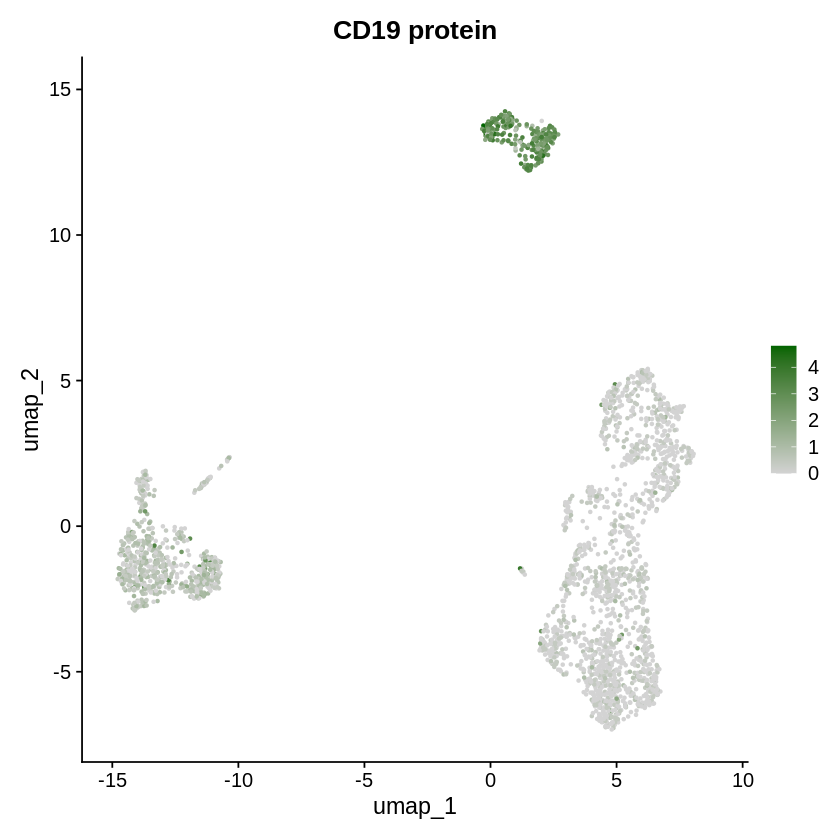

In [ ]:
# Set CITE as the default assay
DefaultAssay(s.clr) <- "CITE"

# Plot UMAP
FeaturePlot(s.clr, "CD19", cols = c("lightgrey", "darkgreen")) + ggtitle("CD19 protein")

# ☕ *Coffee break ☕ (30 min) - (9:30-10:00 h)*

# 5️⃣ **DSB normalization**

DSB (which stands for _**D**enoised and **S**caled by **B**ackground_) is a method developed by Mulé et al. (2022) that takes advantage of empty droplets from single-cell sequencing experiments to estimate and correct for background noise in the read counts from cell-containing droplets.

## 5.1. Background QC

At this point, we have already identified good quality cells in the data. However, this is not enough QC for DSB normalization. Indeed, we need to QC some extra data from the CellRanger output, that is, the read counts from empty droplets. Fortunately, we did tag those barcodes in the `md` dataframe.

In [ ]:
md %>% tibble %>% group_by(drop.class) %>% summarise(n_barcodes=n())

drop.class,n_barcodes
<chr>,<int>
background,389
cell,2611


So we have 389 background droplets. We can use `ggplot` to generate a scatterplot depicting the background (empty droplets) and stained cells (cell-containing droplets). Here, the X-axis has been set as the logarithm of the total number of RNA counts on each given cell (`rna.size`); Similarly, the Y-axis has been set as the logarithm of the total number of ADT counts on each given cell (`prot.size`), allowing us to evaluate the relationship between RNA and ADT counts.

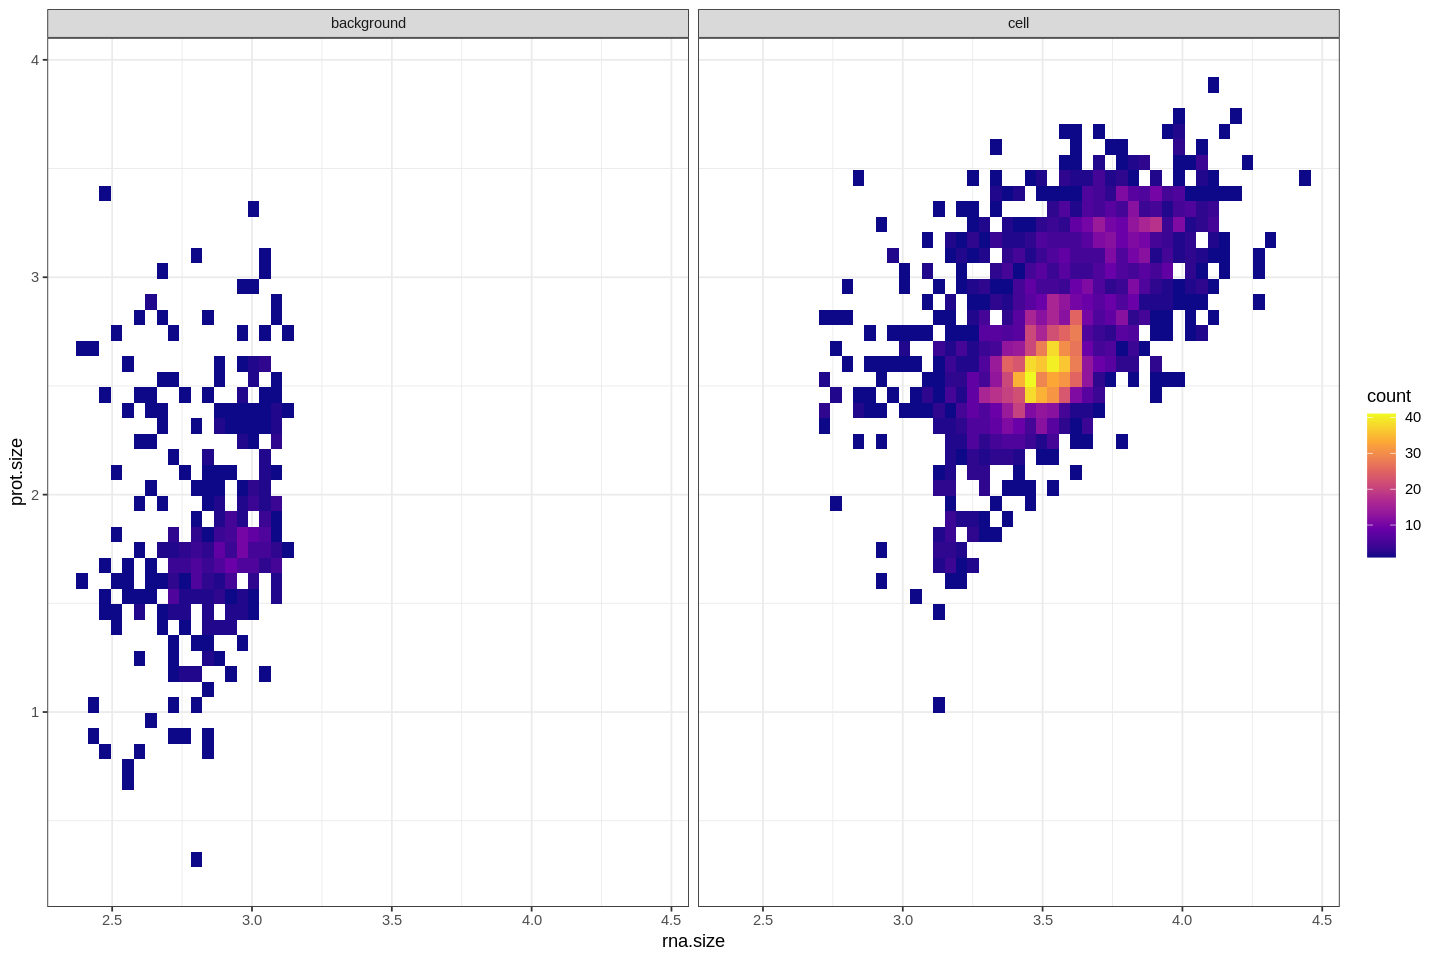

In [ ]:
# Set plot size
options(repr.plot.width = 12, repr.plot.height = 8)

ggplot(md, aes(x = rna.size, y = prot.size)) +
   theme_bw() +
   geom_bin2d(bins = 50) +
   scale_fill_viridis_c(option = "C") +
   facet_wrap(~drop.class)

It is useful to contrast other relevant quality parameters as well, for example, here we are colouring based on the proportion of reads derived from of mitochondrial transcripts.

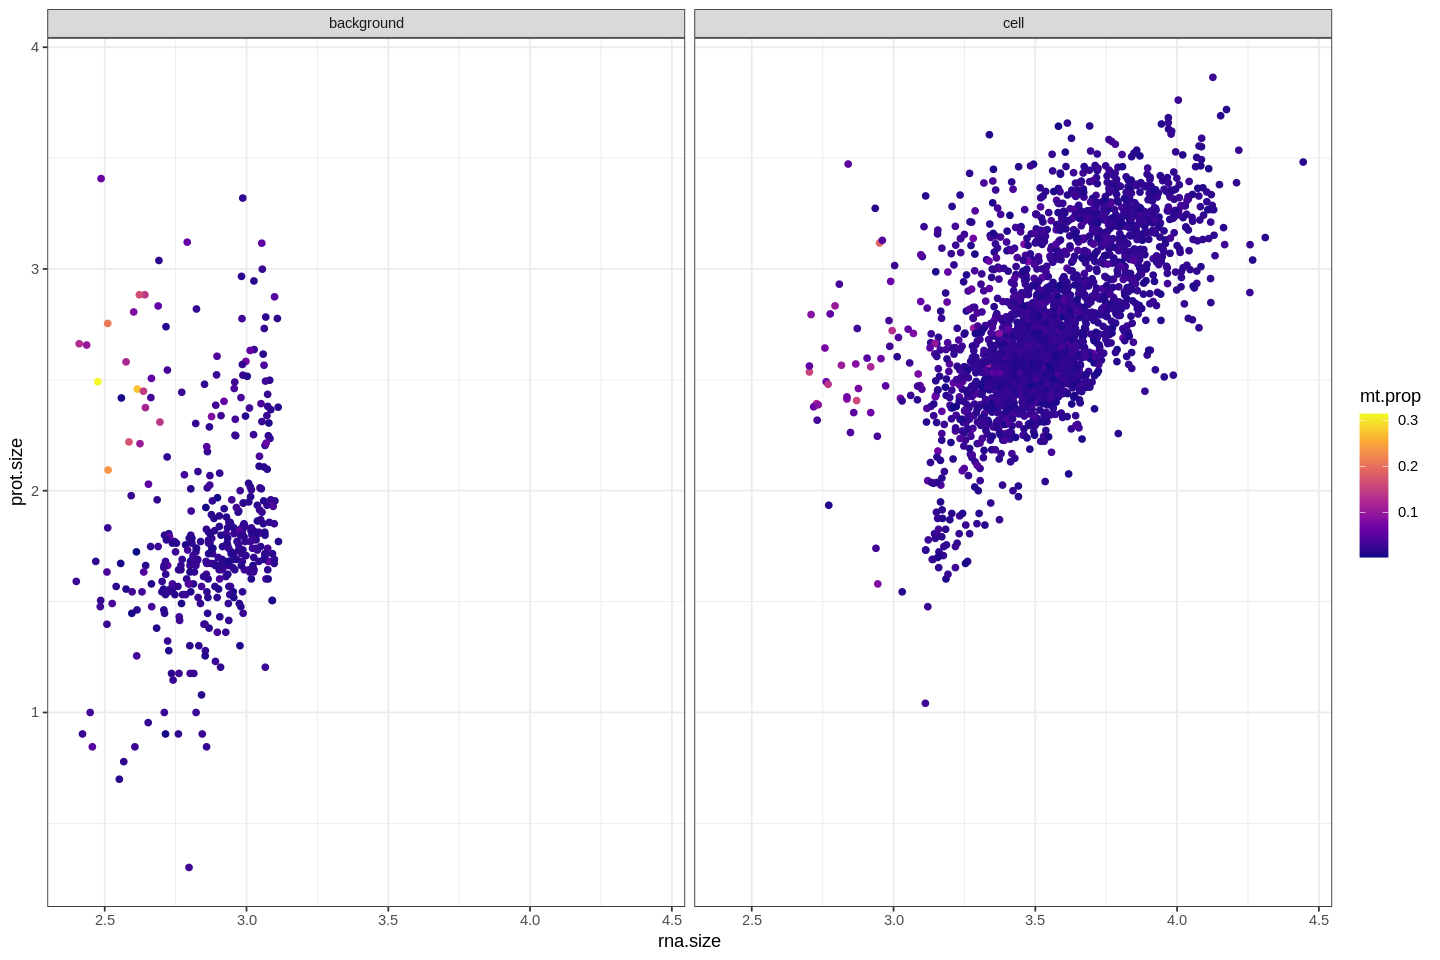

In [ ]:
ggplot(md, aes(x = rna.size, y = prot.size,colour=mt.prop)) +
   theme_bw() +
   geom_point() +
   scale_colour_viridis_c(option = "C") +
   facet_wrap(~drop.class)

These plots are useful to visually define cutoffs and thresholds to determine what part of the data will be considered as actual background. Here, we will consider those droplets that have:
+ A value higher than **1.5** for the logarithm of the total number ADT counts.
+ A value lower than **3** for the logarithm of the total number ADT counts.
+ A value higher than **3.5** for the logarithm of the total number RNA counts.

In [ ]:
# Identify barcodes considered as valid background
background_drops = rownames(
  md[ md$prot.size > 1.5 &
      md$prot.size < 3 &
      md$rna.size < 3.5, ]
  )

# Generate the background matrix
background.adt.mtx = as.matrix(prot[ , background_drops])

Check how many background droplets are left after the QC filtering.

In [ ]:
length(background_drops)

[1] 1311

## 5.2. Generate filtered matrices of RNA and ADT counts

In contrast to the CLR normalization, DSB does not work directly with a Seurat object, instead it requires sparse matrices. Hence, we will generate ADT and RNA matrices with the cells passing the QC only.

In [ ]:
# create ADT matrix
cell.adt.raw = as.matrix(prot[ , qc_cells])

# create RNA matrix
cell.rna.raw = rna[ ,qc_cells]
cellmd = cellmd[qc_cells, ]

# Check that the metadata (md) and count matrices have the same barcodes
stopifnot(isTRUE(all.equal(rownames(cellmd), colnames(cell.adt.raw))))
stopifnot(isTRUE(all.equal(rownames(cellmd), colnames(cell.rna.raw))))

## 5.3. Run DSB normalization

We are almost there. Now you will have to define a vector with the isotype names used in the CITEseq experiment. If you are unsure about which features are the actual isotypes, you can check all the ADT feature names. Usually, they will have the "isotype" word somewhere.

In [ ]:
indexes=grep("isotype", rownames(cell.adt.raw), ignore.case = TRUE)
rownames(cell.adt.raw)[indexes]

[1] "Mouse-IgG1-isotype-Ctrl"           "Mouse-IgG2a-isotype-Ctrl"         
[3] "Mouse-IgG2b-isotype-Ctrl"          "Rat-IgG2b-Isotype-Ctrl"           
[5] "Rat-IgG1-isotype-Ctrl"             "Rat-IgG2a-Isotype-Ctrl"           
[7] "Armenian-Hamster-IgG-Isotype-Ctrl"

In [ ]:
# define isotype controls
isotype.controls = rownames(cell.adt.raw)[indexes]

# normalize and denoise with dsb with
cells.dsb.norm = DSBNormalizeProtein(
  cell_protein_matrix = cell.adt.raw, #cells_citeseq_mtx,
  empty_drop_matrix = background.adt.mtx, #empty_drop_citeseq_mtx,
  denoise.counts = TRUE,
  use.isotype.control = TRUE,
  isotype.control.name.vec = isotype.controls
  )

[1] "correcting ambient protein background noise"
[1] "some proteins with low background variance detected check raw and normalized distributions.  protein stats can be returned with return.stats = TRUE"
 [1] "CD86"                          "CD194-(CCR4)"                 
 [3] "Mouse-IgG2b-isotype-Ctrl"      "Rat-IgG2b-Isotype-Ctrl"       
 [5] "CD146"                         "CD64"                         
 [7] "CD169-(Sialoadhesin-Siglec-1)" "Rat-IgG2a-Isotype-Ctrl"       
 [9] "CD13"                          "CD303-(BDCA-2)"               
[1] "fitting models to each cell for dsb technical component and removing cell to cell technical noise"


In [ ]:
as(cells.dsb.norm,"CsparseMatrix")
cell.rna.raw

  [[ suppressing 33 column names ‘AAACCTGAGTGTACCT-1’, ‘AAACCTGGTTGCCTCT-1’, ‘AAACCTGTCCAGGGCT-1’ ... ]]



137 x 2534 sparse Matrix of class "dgCMatrix"
                                                                        
CD86                               1.05359958 10.0562561304  4.288270514
CD274-(B7-H1-PD-L1)                0.37599567  3.6375291224  0.706953460
CD270-(HVEM-TR2)                   2.90373385  2.1643876374  1.463350855
CD155-(PVR)                        2.59914955  6.0903678853  4.324247412
CD112-(Nectin-2)                   1.86619699  3.1999715692  0.711411019
CD47                               1.61153916  2.1782828700  1.932986412
CD48                               0.40606725  1.0511669653  0.357658578
CD40                               0.38763300  0.1167546083 -0.032778025
CD154                              1.42375789  3.1210525007  1.763682539
CD52                              -0.45468956  0.0960761818 -0.372956009
CD3                               -1.15828842  0.9572751411 -1.026424959
CD8                                0.22164667 -0.0006190698 -0.630181257
CD56 

  [[ suppressing 32 column names ‘AAACCTGAGTGTACCT-1’, ‘AAACCTGGTTGCCTCT-1’, ‘AAACCTGTCCAGGGCT-1’ ... ]]

  [[ suppressing 32 column names ‘AAACCTGAGTGTACCT-1’, ‘AAACCTGGTTGCCTCT-1’, ‘AAACCTGTCCAGGGCT-1’ ... ]]

  [[ suppressing 32 column names ‘AAACCTGAGTGTACCT-1’, ‘AAACCTGGTTGCCTCT-1’, ‘AAACCTGTCCAGGGCT-1’ ... ]]



21713 x 2534 sparse Matrix of class "dgCMatrix"
                                                                                              
AL627309.1    .  .  .   .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
AL627309.5    .  .  .   .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
LINC01409     .  .  .   .  .  .  .  .  .  .  .  .  1  .  .  .  .  .  .  .  .  .  .  .  .  .  1
FAM87B        .  .  .   .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
LINC01128     .  .  .   .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
LINC00115     .  .  .   .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
FAM41C        .  .  .   .  .  .  .  .  .  1  .  .  .  .  .  .  .  .  .  .  .  .  .  .  1  .  .
NOC2L         .  .  .   .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
KLHL17        .  .  .   .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .  .
PL

## 5.4 Join the DSB normalized ADT levels into a Seurat object

In [ ]:
# joining with Seurat
stopifnot(isTRUE(all.equal(rownames(cellmd), colnames(cell.adt.raw))))
stopifnot(isTRUE(all.equal(rownames(cellmd), colnames(cell.rna.raw))))

# create Seurat object note: min.cells is a gene filter, not a cell filter
s.dsb = Seurat::CreateSeuratObject(counts = cell.rna.raw,
                               meta.data = cellmd,
                               assay = "RNA",
                               min.cells = 20)

# Additional steps for downstream visualization of single cell data
DefaultAssay(s.dsb)="RNA"
s.dsb=NormalizeData(s.dsb, normalization.method="LogNormalize", assay="RNA")
s.dsb=ScaleData(s.dsb, features = rownames(s.dsb))
s.dsb=FindVariableFeatures(s.dsb)
s.dsb=RunPCA(s.dsb)
s.dsb=RunUMAP(s.dsb, dims = 1:50)
s.dsb=FindNeighbors(s.dsb, dims=1:50)
s.dsb=FindClusters(s.dsb)

# add dsb normalized matrix "cell.adt.dsb" to the "CITE" data (not counts!) slot
s.dsb@assays$CITE = CreateAssayObject(data = cells.dsb.norm)


Normalizing layer: counts

Centering and scaling data matrix

Finding variable features for layer counts

PC_ 1 
Positive:  IFI30, LYZ, CST3, FCN1, SPI1, S100A9, IL1B, G0S2, S100A8, TNFAIP2 
	   SERPINA1, NLRP3, CSTA, LST1, CTSS, S100A11, TYROBP, PLAUR, VCAN, AIF1 
	   NAMPT, ACSL1, FCER1G, CFD, FAM49A, CD68, IFNGR2, CSF3R, PSAP, HCK 
Negative:  RPS12, EEF1A1, CD69, IFITM1, CXCR4, LTB, MALAT1, IL7R, TSC22D3, CD3D 
	   CD247, TCF7, SPOCK2, CAMK4, CD7, IL32, LEF1, ZFP36L2, TRBC2, BACH2 
	   CD5, ZEB1, ABLIM1, SYNE2, RORA, CD6, ITM2A, PDE3B, CTSW, NOSIP 
PC_ 2 
Positive:  LTB, CD79A, RPLP1, SNX9, MS4A1, LEF1, RPS12, BANK1, CCR7, ZEB1 
	   AFF3, BACH2, RALGPS2, LINC00926, CAMK4, HLA-DRA, MAL, FCRL1, FCER2, TNFRSF13C 
	   ADAM28, RUBCNL, GNG7, FHIT, IGHM, NIBAN3, COBLL1, CHPT1, EBF1, HLA-DRB5 
Negative:  NKG7, CST7, GNLY, CCL5, CTSW, GZMB, GZMA, FGFBP2, GZMH, KLRD1 
	   PRF1, HOPX, B2M, GZMM, KLRF1, SPON2, MATK, EFHD2, PFN1, FCGR3A 
	   S1PR5, IFITM2, KLRK1, KLRC2, ITGB2, C12orf75, CLIC3, P

Modularity Optimizer version 1.3.0 by Ludo Waltman and Nees Jan van Eck

Number of nodes: 2534
Number of edges: 118965

Running Louvain algorithm...
Maximum modularity in 10 random starts: 0.8386
Number of communities: 12
Elapsed time: 0 seconds


In [ ]:
s.dsb

An object of class Seurat 
11944 features across 2534 samples within 2 assays 
Active assay: RNA (11807 features, 2000 variable features)
 3 layers present: counts, data, scale.data
 1 other assay present: CITE
 2 dimensional reductions calculated: pca, umap

# 6️⃣ **Comparison of raw counts, CLR, and DSB normalization**

In [ ]:
# Set plot size
options(repr.plot.width = 12, repr.plot.height = 12)

Picking joint bandwidth of 2.54

Picking joint bandwidth of 0.484

Picking joint bandwidth of 0.843

Picking joint bandwidth of 0.115

Picking joint bandwidth of 0.112

Picking joint bandwidth of 0.124

Picking joint bandwidth of 0.165

Picking joint bandwidth of 0.185

Picking joint bandwidth of 0.0986



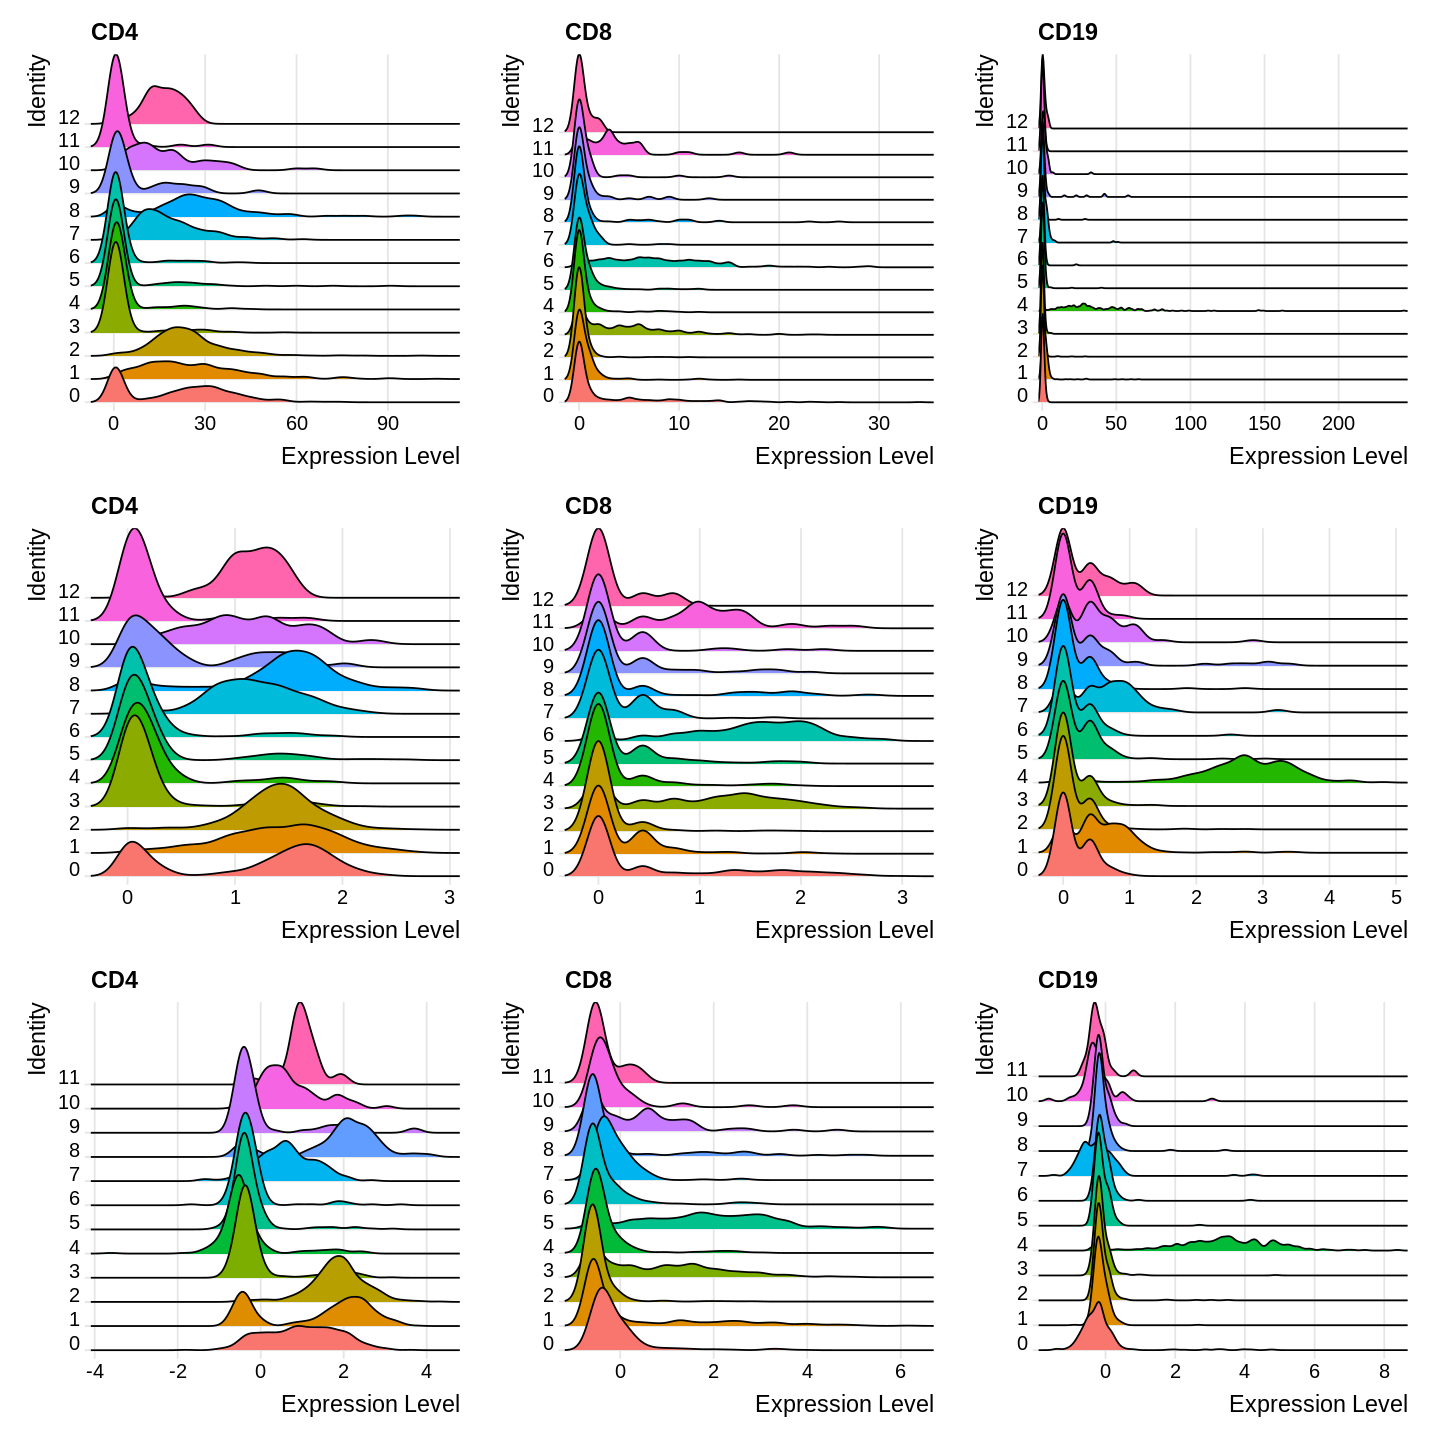

In [ ]:
features=c("CD4","CD8", "CD19")

rawRidge <- RidgePlot(s.clr, features = features, ncol = 3, assay="CITE",layer="counts")
clrRidge <- RidgePlot(s.clr, features = features, ncol = 3, assay="CITE",layer="data")
dsbRidge <- RidgePlot(s.dsb, features = features, ncol = 3, assay="CITE",layer="data")

rawRidge / clrRidge / dsbRidge

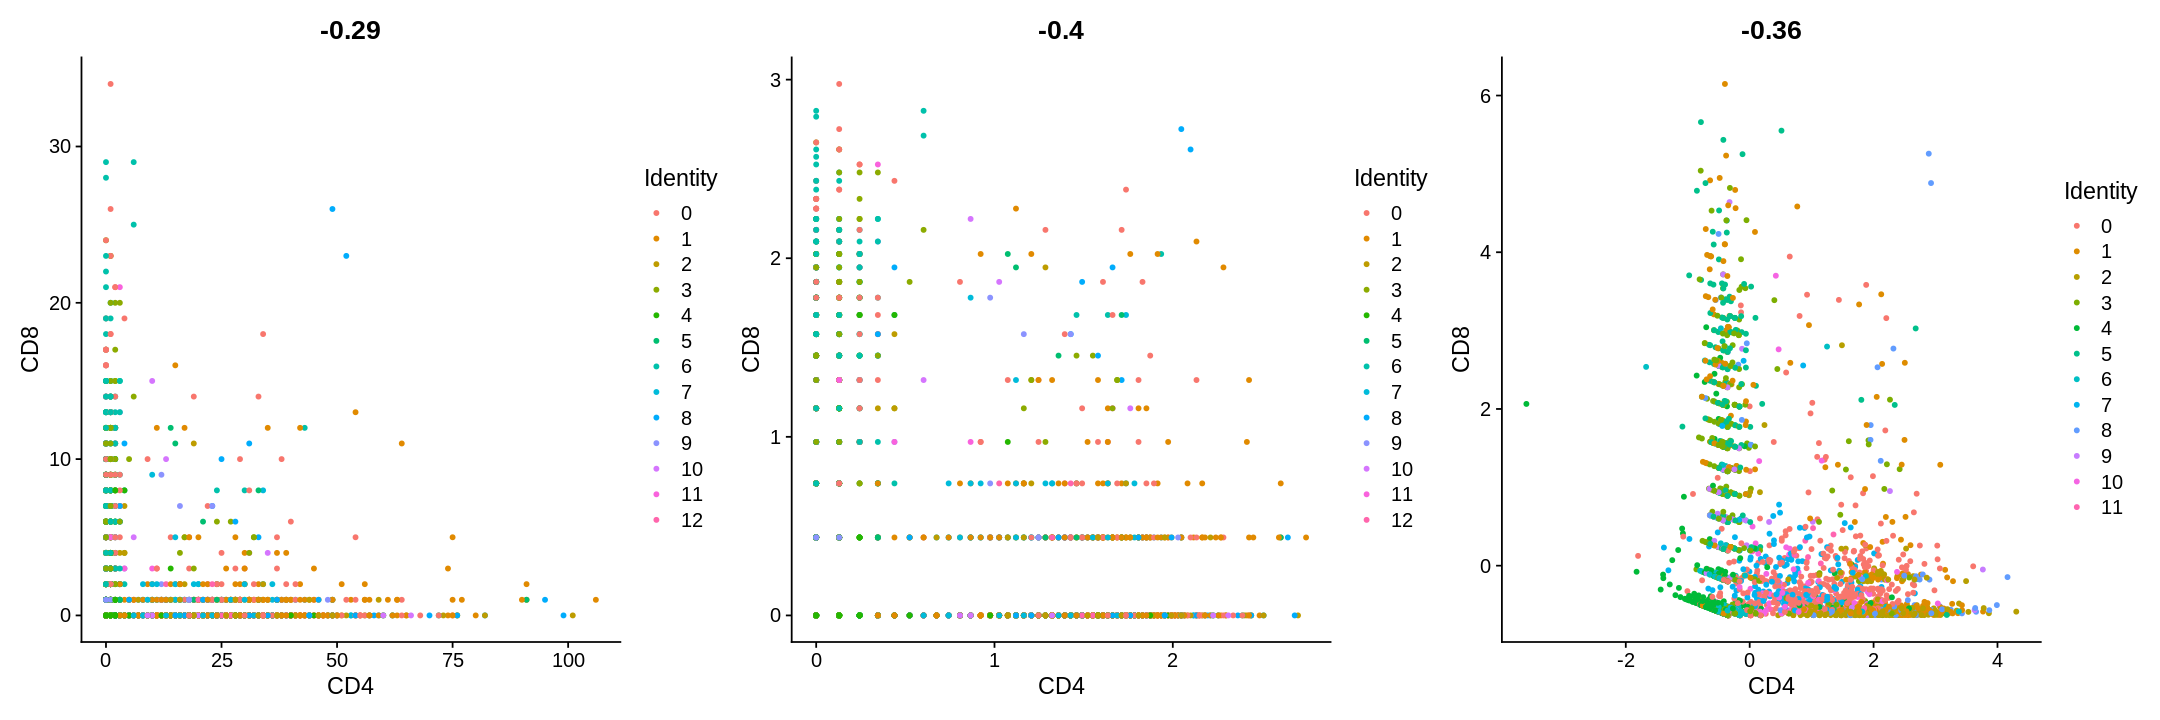

In [ ]:
DefaultAssay(s.clr)="CITE"
DefaultAssay(s.dsb)="CITE"
# Set plot size
options(repr.plot.width = 18, repr.plot.height = 6)
p1sca <- FeatureScatter(s.clr, feature1 = "CD4", feature2 = "CD8", slot = "counts")
p2sca <- FeatureScatter(s.clr, feature1 = "CD4", feature2 = "CD8")
p3sca <- FeatureScatter(s.dsb, feature1 = "CD4", feature2 = "CD8")

p1sca + p2sca + p3sca

# 📗 **References**

1. Stoeckius, M., Hafemeister, C., Stephenson, W., Houck-Loomis, B., Chattopadhyay, P. K., Swerdlow, H., ... & Smibert, P. (2017). Simultaneous epitope and transcriptome measurement in single cells. Nature methods, 14(9), 865-868.
2. Mulè, M. P., Martins, A. J., & Tsang, J. S. (2022). Normalizing and denoising protein expression data from droplet-based single cell profiling. Nature communications, 13(1), 2099.
3. https://www.geo.fu-berlin.de/en/v/soga-r/Advances-statistics/Feature-scales/Logratio_Transformations/index.html
4. https://cran.r-project.org/web/packages/dsb/vignettes/end_to_end_workflow.html